__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. The dec matrix is the weights to pass back an forth (I think), although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from simulations import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [4]:
'''
cond0_dict_list = [0]*num_participants
for idx in range(num_participants):
    cond0_dict_list[idx] = {'training':emgs_block1[keys[idx]][0,:,:], 'labels':refs_block1[keys[idx]][0,:,:]}

with open(path+cond0_filename, 'wb') as fp:
    pickle.dump(cond0_dict_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
init_decoders = [Ws_block1[keys[i]][:, 0, :, :] for i in range(num_participants)]
with open(path+all_decs_init_filename, 'wb') as fp:
    pickle.dump(init_decoders, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''
0

0

# Create Federated Set Up

In [5]:
class ModelBase:
    # Hard coded attributes --> SHARED FOR THE ENTIRE CLASS
    num_updates = 19
    cphs_starting_update = 10
    update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
    
    def __init__(self, ID, w, method, smoothbatch=1, verbose=False, PCA_comps=7, current_round=0):
        self.type = 'Base'  # This gets overwritten but is required for __repr__ below
        self.ID = ID
        self.w = w  # Linear regression weights AKA the decoder
        self.w_prev = copy.copy(w)
        self.dec_log = [w]
        self.local_error_log = []
        self.global_error_log = []
        self.personalized_error_log = []
        self.method = method
        self.current_round = current_round
        self.verbose = verbose
        self.smoothbatch = smoothbatch
        
        self.PCA_comps = PCA_comps
        self.pca_channel_default = 64  # When PCA_comps equals this, DONT DO PCA
        if self.w.shape!=(2, self.PCA_comps):
            print(f"Class BaseModel: Overwrote the provided init decoder: {self.w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, self.PCA_comps)
            self.w_prev = copy.copy(self.w)
        
    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nTraining Method: {self.method}"

In [6]:
class TrainingMethods:
    # Different training approaches
    
    # This one blows up to NAN/overflow... not sure why
    def train_eta_gradstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, PCA_comps):
        grad_cost = np.reshape(gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, Ne=PCA_comps),(2, PCA_comps))
        w_new = w - eta*grad_cost
        return w_new

    def train_eta_scipyminstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, PCA_comps, full=False):
        # I turned off display_info because it's kind of annoying
        if full:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps))#, options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'maxiter':eta}) #'disp': display_info, 
        w_new = np.reshape(out.x,(2, PCA_comps))
        return w_new

In [7]:
class Server(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, current_round=0, PCA_comps=7, verbose=False):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        
        self.set_available_clients_list(init=True)
        
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        if self.method=='FedAvg':
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Send those clients the current global model
            for my_client in self.chosen_clients_lst:
                my_client.global_w = self.w
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
            #^ Note when self.smoothbatch=1 (default), we just keep the new self.w (no mixing)
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        else:
            print('Method not currently supported')
            print('Please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        # Reset all clients so no one is chosen for the next round
        for my_client in self.available_clients_lst:
            my_client.reset_chosen()
        
    # 1.1
    def set_available_clients_list(self, init=False):
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_lst[idx] = my_client
                self.num_avail_clients += 1
                if init:
                    #if self.method != 'NoFL':
                    # Pass down the global METHOD (NOT THE WEIGHTS!!)
                    my_client.global_method = self.method
    
    # 1.2
    def choose_clients(self):
        # Check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_lst, len(self.available_clients_lst))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            print(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        for my_client in client_set:
            my_client.execute_training_loop()
            current_local_lst.append((my_client.ID, my_client.eval_model(which='local')))
            if self.method != 'NoFL':
                current_global_lst.append((my_client.ID, my_client.eval_model(which='global')))
        # Append (ID, COST) to SERVER'S error log.  Note that round is implicit, it is just the index of the error log
        self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's no FL
            self.global_error_log.append(current_global_lst)
    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w
        self.w = aggr_w
        # Still not clear how the global decoder will be able to adapt to different channels for different orientations

In [8]:
class Client(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', eta=1, num_steps=1, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=0, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  If you want NO smoothbatch then set it to 'off'
        '''
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; Stream each update, moving to the next update after local_round_threshold iters have been run; After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_w = None
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        #
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        #
        # ML Parameters / Conditions
        # This should probably be a dictionary at some point
        if condition_number==0:
            self.smoothbatch = 0.25
            self.alphaF = 1e-7
            self.alphaD = 1e-3
        else:
            print("That condition number is not yet supported")
        if smoothbatch=='off':
            self.smoothbatch = 1  # AKA Use only the new dec, no mixing
         
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        local_loss = self.eval_model(which='local')
        # Append (ROUND, COST) to the CLIENT error log
        self.local_error_log.append((self.current_round, local_loss))
        if self.global_method!="NoFL":
            global_loss = self.eval_model(which='global')
            # Append (ROUND, COST) to the CLIENT error log
            self.global_error_log.append((self.current_round, global_loss))
        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self):
        self.current_round += 1
        if self.current_update==17:
            #print("Maxxed out your update (you are on update 19), continuing training on last update only")
            # Probably ought to track that we maxed out
            #lower_bound = update_ix[-2]  # Used to be 0 (e.g. full dataset instead of last update), saw bad behaviour...
            lower_bound = (update_ix[-2] + update_ix[-1])//2  #Use only the second half of each update
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='full_data':
            #print("FULL")
            lower_bound = update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='streaming':
            #print("STREAMING")
            if self.current_round >= self.current_threshold:
                # This had weird behaviour, error increased after first two updates...
                # Switching back to it
                self.current_threshold += self.local_round_threshold
                #self.current_threshold += self.current_threshold
                self.current_update += 1
                if self.verbose==True and self.ID==1:
                    print(f"Client {self.ID}: New update after lrt passed: (new update, current round): {self.current_update, self.current_round}")
                    print()
            #lower_bound = update_ix[self.current_update]
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  #Use only the second half of each update
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='advance_each_iter':
            #print("ADVANCE")
            #lower_bound = update_ix[self.current_update]
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  #Use only the second half of each update
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            self.current_update += 1
        else:
            raise ValueError('This data streaming functionality is not supported')
            
        s_temp = self.training_data[lower_bound:upper_bound,:]
        if self.PCA_comps!=self.pca_channel_default:  # Do PCA unless it is set to 64, AKA just the num channels
            pca = PCA(n_components=self.PCA_comps)
            s_temp = pca.fit_transform(s_temp)
        s = np.transpose(s_temp)
        v_actual = self.w@s
        p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
        p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
        # Now set the values used in the cost function
        self.F = s[:,:-1] # note: truncate F for estimate_decoder
        self.V = (p_reference - p_actual)*self.dt
        self.D = copy.copy(self.w)
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = copy.copy(self.w)
        if self.global_method!="NoFL":
            # Overwrite local model with the new global model
            self.w = self.global_w
        for i in range(self.num_steps):
            if self.method=='EtaGradStep':
                self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
            elif self.method=='EtaScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
            elif self.method=='FullScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
            else:
                print("Unrecognized method")
        # Do SmoothBatch
        # Maybe move this to only happen after each update? Does it really need to happen every iter?
        # I'd have to add weird flags just for this in various places... put on hold for now
        #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
        # Save the new decoder to the log
        self.dec_log.append(self.w)
    
    def reset_chosen(self):
        self.chosen_status = 0
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            my_error_log = self.local_error_log
        elif which=='global':
            my_dec = self.global_w
            my_error_log = self.global_error_log
        else:
            print("Please set <which> to either local or global")
        # This line is why all costs are integers... could try and change it to 2 decimal points but I've heard that frequently doesn't work
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD))
            # Setting to int is just to catch overflow errors, for RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 3)
        return out
        
    def test_inference(self):
        # Essentially, choose a random(?) section of data and compare how dec performs
        # Is this really any different from the eval funcs?
        
        # Would this be generating a new decoder to test on provided data, or just testing the current decoder on it?
        print("Testing Functionality Not Written Yet")
        pass

In [9]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

#pca = PCA(n_components=7)
#new_dec = pca.fit_transform(cond0_init_decs[0])
#print(new_dec.shape)
# Can't do this since 7 < min (2, 64)...

In [10]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

> __Passing in init decoders that are not (2, PCA_comps) AKA (2, 7) will result in the passed in dec getting overwritten to prevent matrix size mismatches.  Can't pass in the init dec from CPHS now because of PCA (unless you turn PCA off of course)__.

Check streaming condition

In [11]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check full data condition

In [12]:
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check advance_each_iter condition

In [13]:
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check the non-PCA case now... this is no longer the default
> This one should overwrite

In [14]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decode

## Double Checking Running the No-FL Case
> We should see some kind of convergence
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT

In [15]:
user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 0

Local Round: 0
Local Update: 0


In [16]:
global_model_no_fl.execute_FL_loop()

print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 1

Local Round: 1
Local Update: 1


In [17]:
# We are at update 2/19.  Therefore 19-2=17-1=16
num_updates_left = 16
for i in range(num_updates_left):
    if i%np.ceil(num_updates_left*.1)==0:
        print(f"Iter {i}")
    global_model_no_fl.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Complete



Global Round: 17

Local Round: 17
Local Update: 17


In [18]:
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

17
17


Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...
> (3: darkorange), (13: deeppink), (1: maroon)

In [51]:
cost_array = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl.local_error_log[i]:
        cost_array[client_id, i] = error

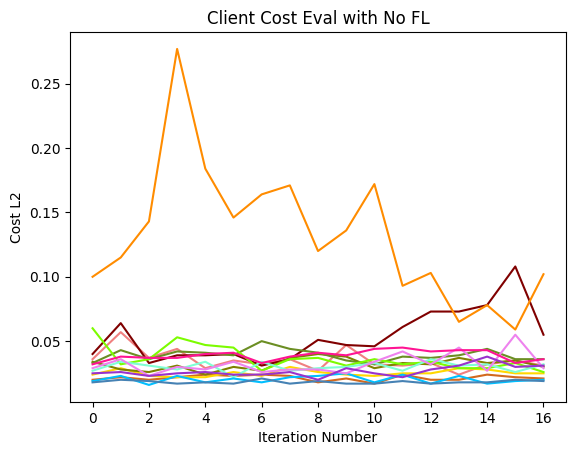

In [52]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.show()

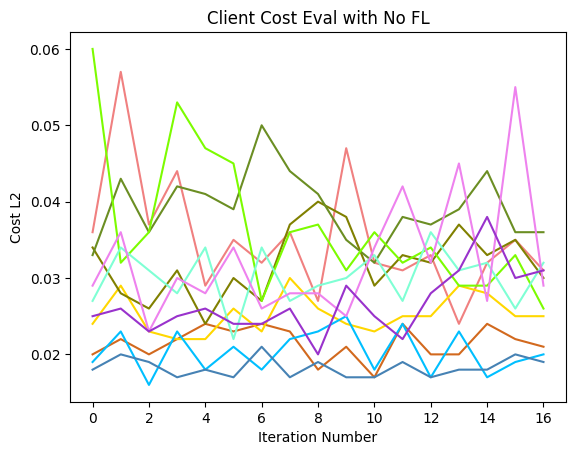

In [53]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

Save Decs to compare to sims

In [22]:
all_user_decs_no_fl = [user_c0_fullscipy[i].dec_log for i in range(num_participants)]

#with open(path+nofl_decs_filename, 'wb') as fp:
#    pickle.dump(all_user_decs_no_fl, fp, protocol=pickle.HIGHEST_PROTOCOL)

Retry but now use the init decs that we loaded in instead of the random inits

In [23]:
#user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
#global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
user_c0_fullscipy_winit = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_winit = Server(-1, D_0, 'NoFL', user_c0_fullscipy_winit, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    if i%5==0:
        print(f"Iter {i}")
    global_model_no_fl_winit.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl_winit.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy_winit[0].current_round}")
print(f"Local Update: {user_c0_fullscipy_winit[0].current_update}")

Iter 0
Iter 5
Iter 10
Iter 15
Complete



Global Round: 18

Local Round: 18
Local Update: 17


In [24]:
cost_array_winit = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl_winit.local_error_log[i]:
        #plt.scatter(i, error, color=id2color[client_id])
        cost_array_winit[client_id, i] = error

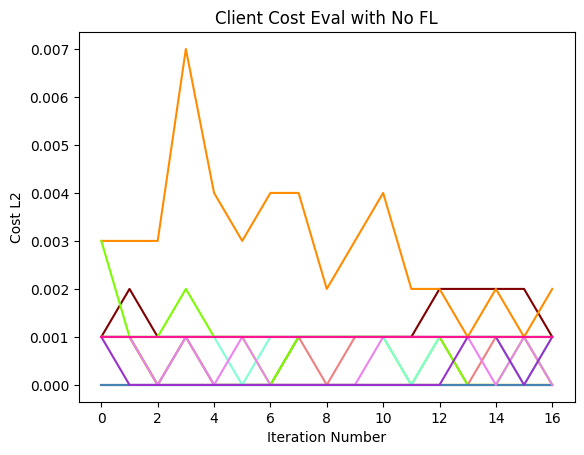

In [25]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.show()

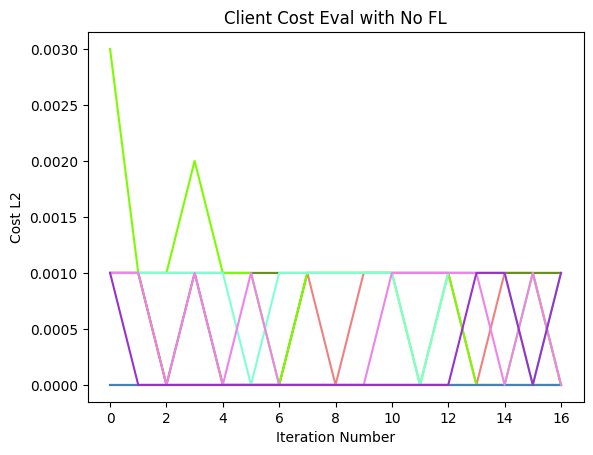

In [26]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

## 1 Scipy Step, 1000 Iterations

In [27]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Iter 1200
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1400
Iter 1600
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1800
Complete


In [28]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(296, 15)
(249, 14)
(272, 15)
(270, 15)
(300, 16)
(273, 15)
(310, 16)
(289, 15)
(270, 15)
(305, 16)
(321, 16)
(280, 15)
(279, 15)
(286, 15)


Local

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800


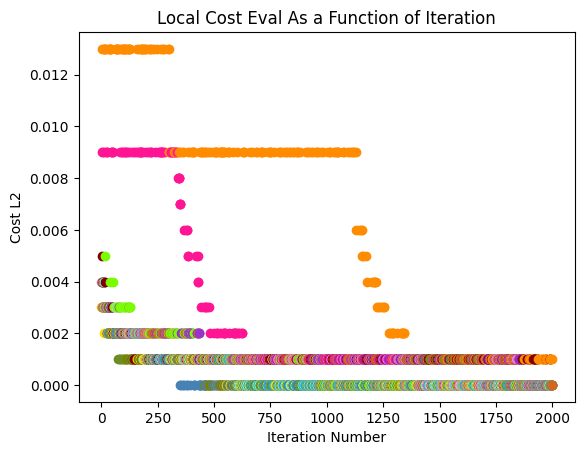

In [54]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.local_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
#plt.ylim(0, 10)
plt.show()

Global

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800


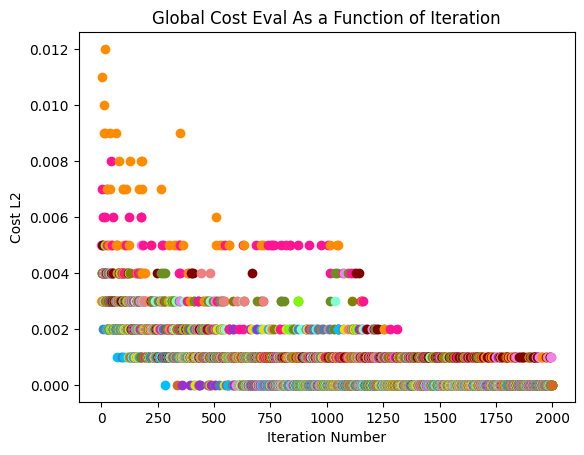

In [55]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.global_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
#plt.ylim(0, 10)
plt.show()

__Redoing but setting the local threshold for update to be much lower__

In [31]:
reduced_limit = 50

In [32]:
user_c0_1ScipyStep_lim50 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim50 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim50)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep_lim50.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Iter 1400
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


Local

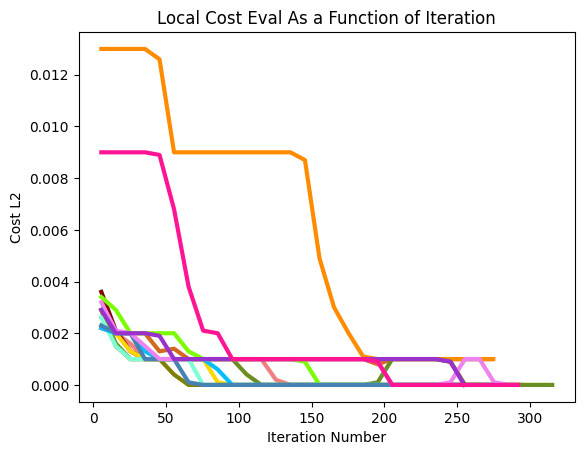

In [33]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

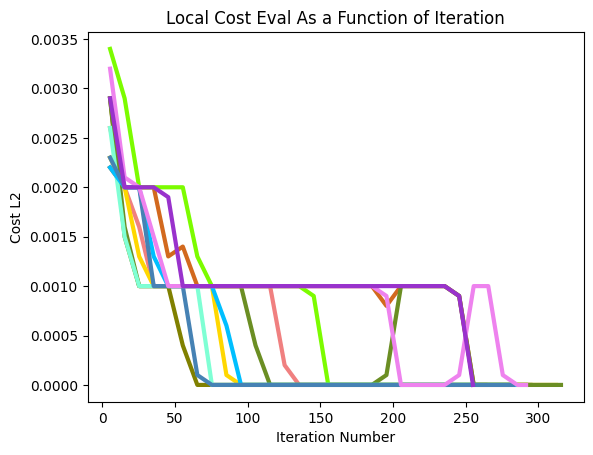

In [34]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

> From earlier run... not sure what changed... 
__Final update cost goes down__
1. 3 darkorange
1. 4 gold
1. 5 olive
1. 6 olivedrab, hardly
1. 7 lawngreen
1. 8 aquamarine
1. 9 deepskyblue
1. 11 violet
<br> <br> 
__Final update cost goes up__
1. 0 lightcoral
1. 1 maroon 
1. 2 chocolate
1. 10 steelblue
1. 12 darkorchid
1. 13 deeppink

Global

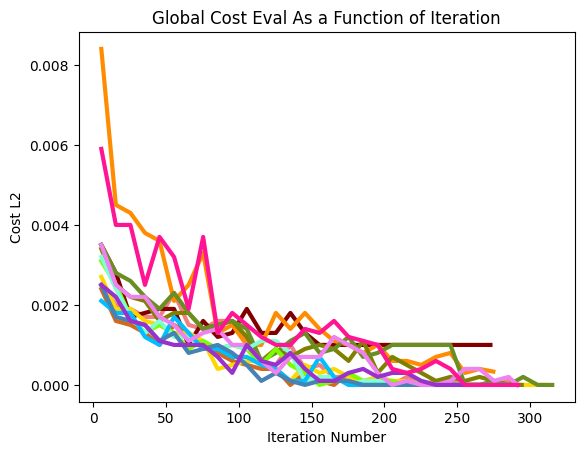

In [35]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

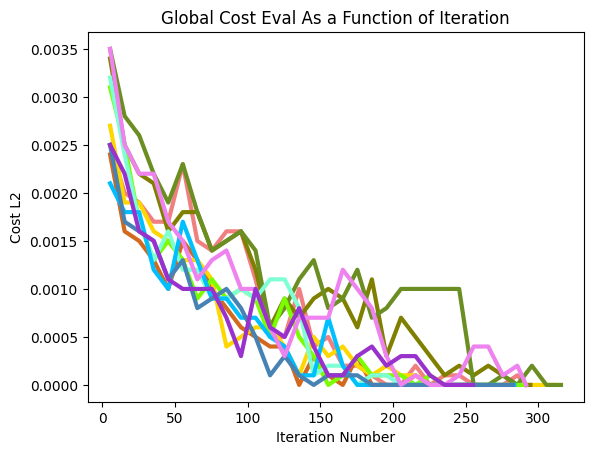

In [36]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

This time, use the final global model as the init instead of a random init
> Compare against using the local model? Doesn't help for new clients...

In [37]:
global_model_1scipystep_lim50.w

array([[ 0.00415761,  0.003645  ,  0.00261561,  0.00101377,  0.00530376,
         0.00166605,  0.01160303],
       [ 0.00301558, -0.00090543,  0.00211901,  0.00105057, -0.00206256,
         0.00218394,  0.01219784]])

In [38]:
user_c0_1ScipyStep_globaldec = [Client(i, global_model_1scipystep_lim50.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globaldecinit = Server(1, global_model_1scipystep_lim50.w, 'FedAvg', user_c0_1ScipyStep_globaldec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_globaldecinit.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1400
Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


In [39]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(254, 15)
(286, 15)
(294, 15)
(276, 15)
(281, 15)
(294, 15)
(290, 15)
(295, 15)
(242, 14)
(313, 16)
(290, 15)
(311, 16)
(298, 15)
(276, 15)


Local

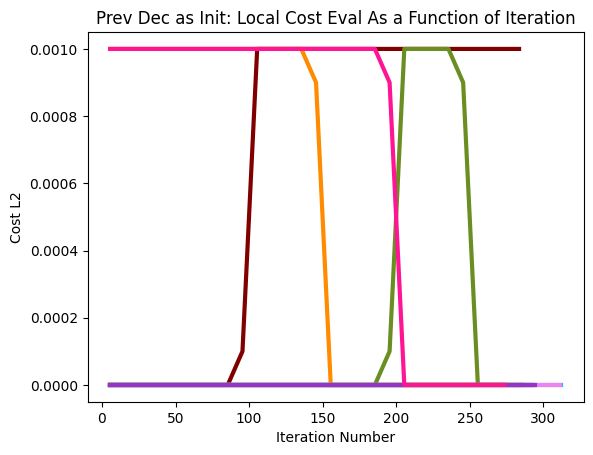

In [40]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_local_log = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].local_error_log)
    df_local_log10 = df_local_log.groupby(df_local_log.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_local_log10.values[:, 0], df_local_log10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Local Cost Eval As a Function of Iteration')
plt.show()

Global

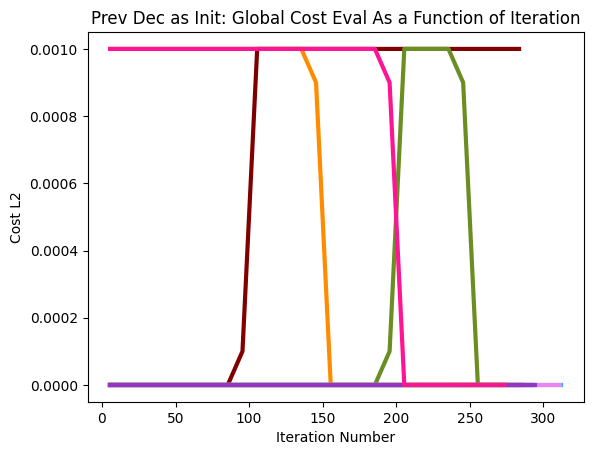

In [41]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_global_error = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].global_error_log)
    df_global_error10 = df_global_error.groupby(df_global_error.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_global_error10.values[:, 0], df_global_error10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Global Cost Eval As a Function of Iteration')
plt.show()

I can't tell much difference between the sets of plots, using the Previous Global Dec as the init...

## 10 Steps

In [42]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_10scipy.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800
Complete


In [43]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(254, 15)
(286, 15)
(294, 15)
(276, 15)
(281, 15)
(294, 15)
(290, 15)
(295, 15)
(242, 14)
(313, 16)
(290, 15)
(311, 16)
(298, 15)
(276, 15)


Local

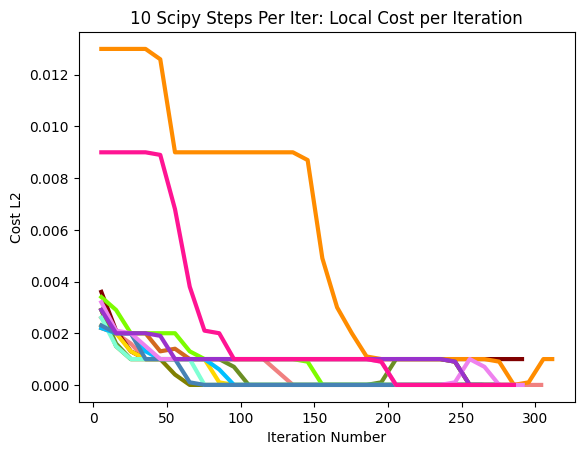

In [44]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_local_log = pd.DataFrame(user_c0_10scipy[i].local_error_log)
    df_local_log10 = df_local_log.groupby(df_local_log.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_local_log10.values[:, 0], df_local_log10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Local Cost per Iteration')
plt.show()

Global

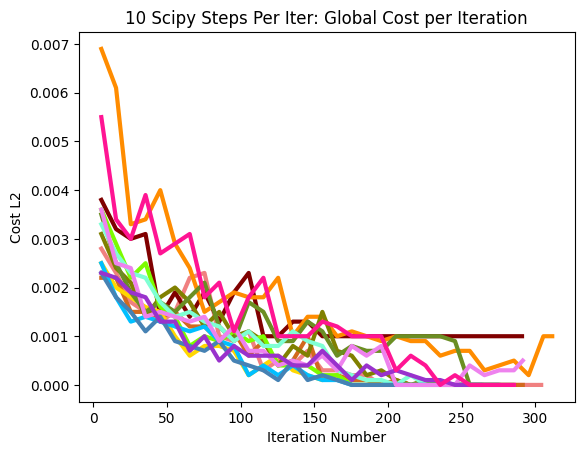

In [45]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_global_error = pd.DataFrame(user_c0_10scipy[i].global_error_log)
    df_global_error10 = df_global_error.groupby(df_global_error.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_global_error10.values[:, 0], df_global_error10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Global Cost per Iteration')
plt.show()

## Full Scipy.Minimize

In [46]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(18):
    if i%np.ceil(18*.1)==0:
        print(f"Iter {i}")
    global_model_fullscipy.execute_FL_loop()
print("Complete")

#cost_array = np.zeros((num_participants,17))
#for i in range(17):
#    for (client_id, error) in global_model_no_fl.local_error_log[i]:
#        cost_array[client_id, i] = error

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Complete


Local

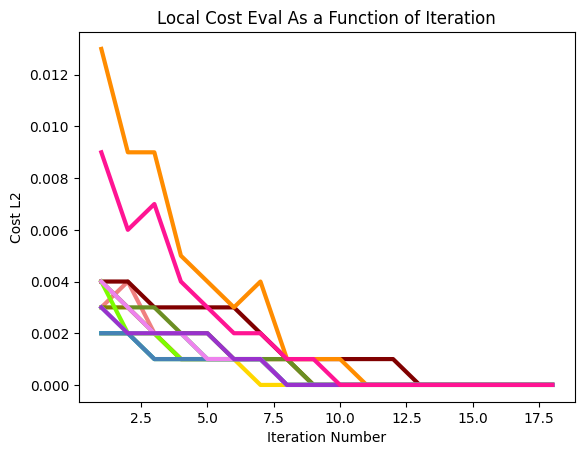

In [47]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].local_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
           
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

Global

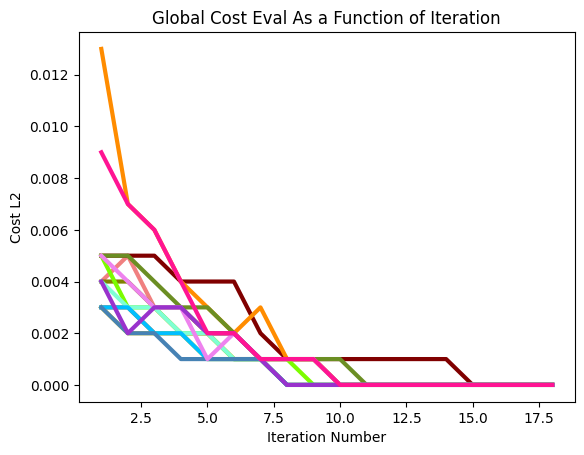

In [48]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].global_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
 - APFL
<br> <br>
Cesar/Taha Paper
 - 
 - 
 - 
<br> <br>
Misc
- PFA: PP F Adaptation for Effective Model Personalization
<br> <br>
Papers I have read and think I could try
- Pers RT FL for Epileptic Seizure Detection
<br> <br>
Papers I haven't read yet
- An Efficient Framework for Clustered FL
- Pers FL with DP
<br> <br>
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

In [49]:
assert(1==0)

AssertionError: 

In [ ]:
# Remember to set smoothbatch='off'

In [ ]:
#mew strongly convex...
eta_t = 16 / (mew*(t+a))
a = np.max(128*K, Tau)
K = L/mew
p_t = (t+a)^2
S_T = np.sum(p_t)

In [ ]:
#for t in rounds:
running_dec_aggr = 0
for my_client in self.chosen_clients_lst:
    if self.current_round%self.tau!=0:  # "t not divides Tau"
        my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
        # What is smallChi, is it kept locally or globally?
        # Do eta and smallChi actually vary for each round? Do I NEED to track previous values for those?
        # Tau --> After Tau local updates, the global models are pushed back to the server
        # Grad is the stochastic gradient evaluated at minibatch smallChi
        my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
        my_client.v_bar = my_client.alpha*my_client.local_w - (1 - my_client.alpha) * my_client.global_w
        # Update U? Select new clients I think
    else:
        # Aggregate clients global models
        running_dec_aggr += my_client.global_w
if self.current_round%self.tau==0:
    # Eg only run this for the else case
    self.global_w = (1/U)*running_dec_aggr  # What is 1/|Ut|?  Why didn't they just use K
    # Their pseudo code says to broadcast new global_w to a new set of chosen clients
for my_client in (set(self.available_clients_lst) ^ set(self.chosen_clients_lst)):  # Symmetric Difference for sets
    # Is this supposed to be a new Ut? That wouldn't make much sense to me
    my_client.local_w = my_client.local_w
    # Does this even need to happen idk why they do this... just to advance the index or is there another reason

running_dec_aggr = 0
for my_client in self.available_clients_lst:
    running_dec_aggr += my_client.global_w
    running_pt_dec_aggr += p_t
for my_client in self.available_clients_lst:  # What is tin...
    # "Output"
    # v hat
    # What is S_T lol
    #my_client.personalized_w = (1/S_T)*
    #sum from t=1 to T of p(my_client.alpha)
    # w hat
    my_client.global_w = (1/(K*S_T))
    #self.dec_log
    
    

## Personalized Asynchronous Federated Learning (Taha+Cesar)
> https://arxiv.org/pdf/2210.01176.pdf

In [ ]:
assert(1==0)

Basic AFL
> My code is not configured to run this way, although this way is the most realistic (server waits for client responses).  Ideally would have some way to weight different clients if there are some that are spamming, or generally just faster than others and contributing more.

In [ ]:
# Repeat until converged...
# how do you know in a decentralized way lol
#if self.update_recieved:
#    self.w -= self.beta*self.latest_update

Personalized AFL

In [ ]:
#input: number of local steps Q, local stepsize η, MAML stepsize α, Moreau Envelope (ME) regularization parameter λ, minimum batch size b, estimation error ν.

# Do client selection

for my_client in self.chosen_clients_lst:
    my_client.global_w = self.w
    for q in range(Q):
        #"Sample a data batch D_{i, q} from distribution p_i"
        
        # OPTION A (AFL) --> Just what is shown in the cell above
        if self.global_method=='AFL':
            # Server doesn't have client's grad input info... eg FDHV
            # In their model/code, does the client send the params or the new weight?
            
            # Eqn 5 is the original
            # Eqn 9 is the biased estimation of 5, shown below
            self.w -= self.eta*gradient_cost_l2(self.F,self.D,self.H,self.V,self.learning_batch,self.alphaF,self.alphaD)
        # OPTION B (PersA-FL: MAML)
        elif self.global_method=='PersA_FL_MAML':
            #"Sample 2 databatches from distribution p_i"
            # I have no idea what these terms are lol
            # I don't think I can use the analytical cost funcs here either now
            self.w -= self.eta*(I-alpha*Hessian(self.w, D_dd))*grad(self.w-alpha*grad(D_d), D)
        # OPTION C (PersA-FL: ME)
        elif self.global_method=='PersA_FL_ME':
            self.h = f(theta_i, D) + lambda*0.5*(np.linalg.norm(theta_i - self.w)^2)
            #"Minimize h wrt theta_i up to accuracy level v to find theta_tilde_i"
            #np.linalg.norm(grad_h(theta_tilde_i(self.w), self.w, D)) <= v
            #scipy.minimize(...)
            self.w -= self.eta*lambda*(self.w - theta_tilde_i(self.w))
        
        # ELSE
        else:
            print(f'Global method {self.method} not defined, please select one from the following: {self.implemented_global_training_methods}')
delta_i = self.w_i_0 - self.w_i_Q
# client i broadcasts delta_i to the server
#"Repeat until not interrupted by the server"